# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Minibatch size in the wine dataset
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [2]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import sys
sys.path.append("../myUtils")  # add parent directory to path to import myGraph

from myDeep import trainModel


# Import and process the data
## Normalization & Binarization

In [3]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
data = data[data["total sulfur dioxide"] < 200]  # drop a few outliers

# z-score all columns except for "quality" (NORMALIZATION)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop("quality")
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality (BINARY CLASSIFICATION)
data["boolQuality"] = 0

# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
# data["boolQuality"][data["quality"] > 5] = 1  # WARNING (Trying to set value on a copy of a slice from a DataFrame)
data.loc[data["quality"] > 5, "boolQuality"] = 1  # loc: "Access a group of rows and columns by label(s) or a boolean array"

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0


In [4]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(data):
    # Round columns 'fixed acidity', 'volatile acidity' and 11 other columns (Number of decimals: 2)
    data = data.round({'fixed acidity': 2, 'volatile acidity': 2, 'citric acid': 2, 'residual sugar': 2, 'chlorides': 2, 'free sulfur dioxide': 2, 'total sulfur dioxide': 2, 'density': 2, 'pH': 2, 'sulphates': 2, 'alcohol': 2, 'quality': 2, 'boolQuality': 2})
    return data

data_clean = clean_data(data.copy())
data_clean.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.53,0.96,-1.39,-0.45,-0.24,-0.46,-0.38,0.56,1.29,-0.58,-0.96,5,0
1,-0.30,1.97,-1.39,0.05,0.22,0.88,0.65,0.03,-0.72,0.13,-0.58,5,0
2,-0.30,1.30,-1.19,-0.17,0.10,-0.08,0.25,0.13,-0.33,-0.05,-0.58,5,0
3,1.65,-1.39,1.49,-0.45,-0.27,0.11,0.43,0.66,-0.98,-0.46,-0.58,6,1
4,-0.53,0.96,-1.39,-0.45,-0.24,-0.46,-0.38,0.56,1.29,-0.58,-0.96,5,0


# Re-organize the data: train/test in DataLoaders

In [5]:
features = data[cols2zscore].values
labels = data["boolQuality"].values

# convert from pandas dataframe to tensor
dataT  = torch.tensor(features).float()  # using normalized data
labelsT = torch.tensor(labels).float() # using normalized data
labelsT = labelsT[:,None] # transform to matrix

In [6]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labelsT, test_size=0.1
)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

# Now for the DL part

In [7]:
# create a class for the model

class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(11, 16)

        ### hidden layers
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        ### output layer
        self.output = nn.Linear(32, 1)

    # forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))  # fully connected
        x = F.relu(self.fc2(x))
        
        return self.output(x)

# Train the model

In [8]:
# train the model and get the losses
ANNmodel = ANNwine()
train_loader = DataLoader(train_dataDataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataDataset, batch_size=16, shuffle=True)

trainAcc, testAcc, losses = trainModel(
    ANNmodel, train_loader, test_loader, numepochs=500, learningRate=0.2
)

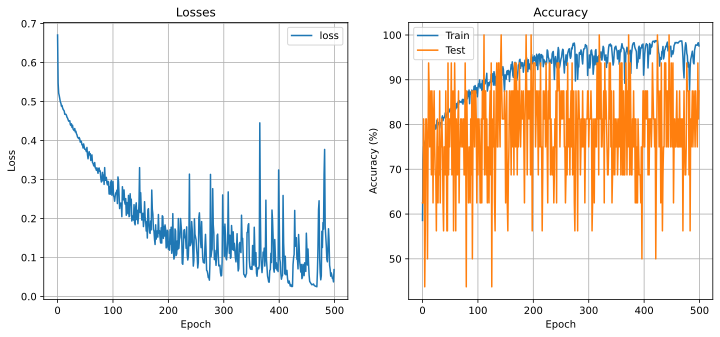

In [9]:

# plot the losses and accuracies in different subplots
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(losses.detach().numpy())
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses')
ax[0].legend(['loss'])
ax[0].grid(True)

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy')
ax[1].grid(True)
ax[1].legend(['Train','Test'])

plt.show()


# Now for the experiment

In [10]:
# This cell takes ~15 mins

# range of batch sizes
batchsizes = 2 ** np.arange(1, 10, 2)

numepochs = 100

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))
lossesResults = np.zeros((numepochs, len(batchsizes)))
comptime = np.zeros(len(batchsizes))

# test data doesn't vary by training batch size
test_loader = DataLoader(
    test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0]
)

# loop over batch sizes
for bi in range(len(batchsizes)):
    # start the clock!
    starttime = time.process_time()

    # create dataloader object
    train_loader = DataLoader(
        train_dataDataset, batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True
    )

    # create and train a model
    winenet = ANNwine()
    trainAcc, testAcc, losses = trainModel(
        winenet, train_loader, test_loader, numepochs=numepochs, learningRate=0.2
    )

    # store data
    accuracyResultsTrain[:, bi] = trainAcc
    accuracyResultsTest[:, bi] = testAcc
    lossesResults[:, bi] = losses.detach().numpy()

    # check the timer
    comptime[bi] = time.process_time() - starttime

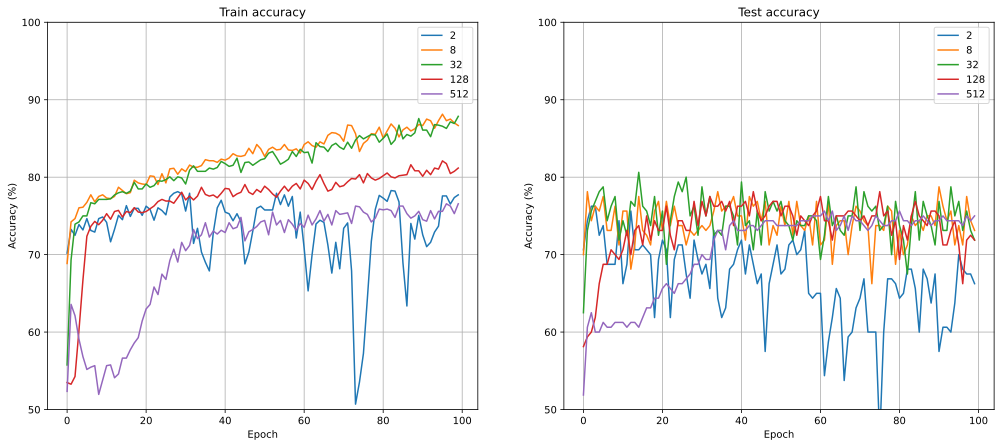

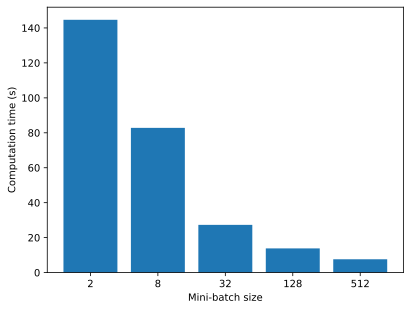

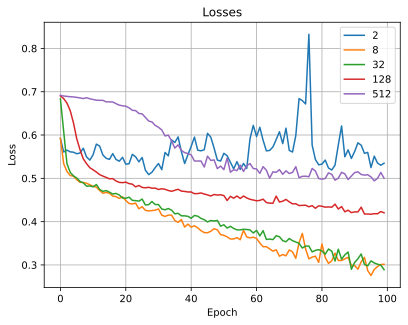

In [17]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title("Train accuracy")
ax[1].plot(accuracyResultsTest)
ax[1].set_title("Test accuracy")

# common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 100])
    ax[i].grid()

plt.show()


# bar plot of computation time
plt.bar(range(len(comptime)), comptime, tick_label=batchsizes)
plt.xlabel("Mini-batch size")
plt.ylabel("Computation time (s)")
plt.show()

# losses plot
plt.plot(lossesResults) # [:,1:])
plt.legend(batchsizes) # [1:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses")
plt.grid()
plt.show()

# Additional explorations

In [12]:
# 1) There is another regularization technique called "early stopping," which simply means to stop training the model
#    earlier than the number of epochs you specified. Early stopping is used when the test accuracy starts to decrease
#    with increased training. Do you think that early stopping would be beneficial here? How many epochs would you train?
# 
# 2) The training loop computes the losses, but those aren't plotted. Create an additional subplot to show the losses
#    in a similar fashion as the accuracy. Does that plot provide any additional insights into the effects of minibatch
#    size, beyond what we can already learn from the accuracy plots.
# 